# Q8 Analyze HRV

Dig into the Rhinovirus results in the Q8 sequencing run.

In prior RespiCoV analyses I've relied on hits caching to enable fast analysis. But in Q8 I have a ton more data (28 Gb uncompressed, 22M reads) using a variety of different primers, as well as a lot of samples using only Rhinovirus primers. So rather than use hits caching, let's just split out the entire set of Rhinovirus hits and operate on that. 

This looks over all sequencing reads for the HRV 5' UTR region targetted by the RespiCoV Enterovirus primer pair. Most experiments actually used the HRVKa5 primer set, but they different from ENT rc only in the reverse primer extending 2 bases further beyond the amplicon, so we can just ignore that.

Note that these samples also include a full-genome HRV sequence which we want to exclude.
Reads were basecalled and demuxed with Dorado 0.7.3, using the sup@v5.0.0 model and without barcodes and adapters trimming.
Reads have not yet been filtered for quality, we do that here.

## Setup

In [35]:
from Bio import Align
import matplotlib_inline.backend_inline
import os
import pandas as pd
import RCUtils
import random
import numpy as np
import Bio

%load_ext autoreload
%autoreload 1
%aimport RCUtils

# Be deterministic
random.seed(42)

fastQDir = "../Q8/reads-sup/"
hrvDir = "../Q8/reads-sup-hrv/"

pd.options.display.max_rows = 50
pd.options.display.min_rows = 25

print("BioPython version:", Bio.__version__)

# Get the Rhinovirus primer pair.
rcPrimers = RCUtils.readPrimers("RespiCovPrimers.fasta")
hrvPrimers = [p for p in rcPrimers if p.description == "Rhinovirus/Enterovirus 1" or p.description == "Rhinovirus/Enterovirus 3"]
barcodes = RCUtils.readPrimers("ONTBarcodes.fasta", addRc=False, addRandom=False)
adapters = RCUtils.readPrimers("ONTAdapters.fasta", addRc=False, addRandom=False)
print("Rhinovirus primers:", [str(p.seq) for p in hrvPrimers])


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
BioPython version: 1.80
Rhinovirus primers: ['CAAGCACTTCTGTTTCCCCGG', 'AACACGGACACCCAAAGTAGT']


## Utilities

In [128]:
import math

# Get the hits across all files but allow a limit on the number of reads per file.
# Many files have over a million reads.
def getAllPrimerHits(maxReadsPerFile = 0, progress = False, skipReads = 0):
    for file in sorted(filter(lambda f: f.endswith(".fastq"), os.listdir(fastQDir))):
        for (read, hit) in getPrimerHits(file, maxReadsPerFile, progress, skipReads):
            yield (file, read, hit)

# Get primer hits for a single file
def getPrimerHits(file, maxReadsPerFile = 0, progress = False, skipReads = 0, matchThreshold = RCUtils.MATCH_THRESHOLD, primers=hrvPrimers):
    fastQPath = os.path.join(fastQDir, file)
    if not os.path.exists(fastQPath) and os.path.exists(fastQPath + ".gz"):
        fastQPath += ".gz"
    if progress:
        print("Processing ", os.path.basename(fastQPath), end="")
    reads = 0
    hitReads = 0
    for read in RCUtils.readFastQ(fastQPath):
        reads += 1
        if reads <= skipReads:
            continue
        hits = RCUtils.computePrimerHits(read, primers, matchThreshold=matchThreshold)
        if hits:
            hitReads += 1
            yield (read, hits)
        if maxReadsPerFile and reads >= skipReads + maxReadsPerFile:
            break
    if progress:
        totalReads = max(reads - skipReads, 0)
        print(" %d reads, %d with hits (%d%%)" % (totalReads, hitReads, hitReads * 100 / totalReads if totalReads else 0))

# Compute an overall probability of error as a phred score
# This tends to higly penalize a single error, so may not be as useful as the mean phred score
def overallPhredScore(phred_scores):
    # Phred scores represent the probability of error, eg. with 10 being 1 in 10, 20 being 1 in 100, etc.
    total_error_prob = 1 - math.prod(1 - 10 ** (-q / 10) for q in phred_scores)
    if total_error_prob == 0:
        return float('inf')
    return -10 * math.log10(total_error_prob)

# Print an alignment with an additional track indicating the quality scores of the read
def printAlignmentWithQuality(alignment, read):
    assert(alignment.target is read.seq)
    quality_scores = read.letter_annotations["phred_quality"]
    
    # Initialize strings for the aligned target, query, alignment string, and query quality scores
    aligned_target = ""
    aligned_query = ""
    alignment_string = ""
    aligned_target_quality = ""
    
    # Use indices to determine where gaps are and construct the alignment, target, query, and quality strings

    for t_index, q_index in zip(*alignment.indices):
        aligned_target += alignment.target[t_index] if t_index != -1 else "-"
        aligned_query += alignment.query[q_index] if q_index != -1 else "-"
        alignment_string += "|" if t_index != -1 and q_index != -1 and alignment.target[t_index] == alignment.query[q_index] else "."
        if t_index == -1:
            aligned_target_quality += "-"
        else:
            ns = quality_scores[t_index] // 4
            aligned_target_quality += str(ns) if ns < 10 else "9"

    tstart = alignment.indices[0,0]
    tend = alignment.indices[0,-1]
    print("  target quality     ", aligned_target_quality, "  avg:", int(np.mean(quality_scores[tstart:tend])))
    print("  target             ", aligned_target)
    print("                     ", alignment_string)
    print("  query              ", aligned_query)
    print("")

# Print the hits for a read
def printHits(read, hits):
    print ("%s %d" % (read.id, len(read)))
    for hit in hits:
        print("   %.2f %i-%i: %s (%d%s)" % (hit.mr, hit.start, hit.end, hit.primer.description, len(hit.primer), " rev" if hit.rev else ""))
        aligner = Align.PairwiseAligner(mode='local', match_score=1, mismatch_score=0, gap_score=-1)
        alignment = aligner.align(read.seq, hit.primer.rcSeq if hit.rev else hit.primer.seq)[0]
        RCUtils.extendAlignment(alignment)
        printAlignmentWithQuality(alignment, read)

# Function to parse a UCLUST-like file
def parseUclust(input_file):
    clusters = {}
    cluster_order = []
    with open(input_file, 'r') as f:
        for line in f:
            columns = line.strip().split('\t')
            cluster_id = int(columns[1])
            if columns[0] == 'S':
                # Initialize a new cluster entry for a centroid record
                clusters[cluster_id] = {
                    'id': cluster_id,
                    'centroid': {
                        'length': int(columns[2]),
                        'readId': columns[8],
                    },
                    'hits': [],
                    'cluster_size': 0
                }
            elif columns[0] == 'H':
                # Append hit information to the corresponding cluster
                clusters[cluster_id]['hits'].append({
                    'length': int(columns[2]),
                    'similarity': columns[3],
                    'orientation': columns[4],
                    'readId': columns[8],
                })
            elif columns[0] == 'C':
                clusters[cluster_id]['cluster_size'] = int(columns[2])
                cluster_order.append(cluster_id)
    return (clusters, cluster_order)

## Get an idea for the distribution of reads with hits

Barcodes 1 to 7 are our main HRV samples and as expected have the bulk of the hits.
Barcodes 19-21 are RespiCoV and so are expected to have some HRV.
Barcode 18 is the HRV-C1 full genome. Why don't we see hits here? Shouldn't I have to filter out these ~1200bp HRV hits?
A few of the other hits occur in samples using other RespiCov primers but not HRV, why?

In [4]:
hitCount = 0
for (inFile, read, hits) in getAllPrimerHits(maxReadsPerFile=1000, progress=True):
    hitCount += len(hits)

print("Total hits:", hitCount)

Processing  Q8-sup_barcode01.fastq 1000 reads, 968 with hits (96%)
Processing  Q8-sup_barcode02.fastq 1000 reads, 900 with hits (90%)
Processing  Q8-sup_barcode03.fastq 1000 reads, 953 with hits (95%)
Processing  Q8-sup_barcode04.fastq 1000 reads, 883 with hits (88%)
Processing  Q8-sup_barcode05.fastq 1000 reads, 926 with hits (92%)
Processing  Q8-sup_barcode06.fastq 1000 reads, 923 with hits (92%)
Processing  Q8-sup_barcode07.fastq 1000 reads, 980 with hits (98%)
Processing  Q8-sup_barcode08.fastq 1000 reads, 0 with hits (0%)
Processing  Q8-sup_barcode09.fastq 1000 reads, 4 with hits (0%)
Processing  Q8-sup_barcode10.fastq 1000 reads, 4 with hits (0%)
Processing  Q8-sup_barcode11.fastq 1000 reads, 11 with hits (1%)
Processing  Q8-sup_barcode12.fastq 1000 reads, 411 with hits (41%)
Processing  Q8-sup_barcode13.fastq 1000 reads, 4 with hits (0%)
Processing  Q8-sup_barcode14.fastq 1000 reads, 124 with hits (12%)
Processing  Q8-sup_barcode15.fastq 1000 reads, 1 with hits (0%)
Processing  

## Look at the first few hits in detail just to sanity check

These look good. Primer pair hits at the exact start and end of the trimmed read.
Mismatches seem to be in areas of low basecall quality.

In [6]:
from Bio import Align

for (read, hits) in getPrimerHits("Q8-sup_barcode01.fastq", maxReadsPerFile=5):
    printHits(read, hits)


90356f32-2337-4543-a50b-390d2113b4af 448
   0.95 72-93: Rhinovirus/Enterovirus 1 (21)
target quality      999999999998898644347   avg: 35
target              CAAGCACTTCTGTTTCCCGGG
                    ||||||||||||||||||.||
query               CAAGCACTTCTGTTTCCCCGG

cf7c2352-560f-403a-9f50-9066bdfe5c37 177
   1.00 105-126: Rhinovirus/Enterovirus 1 (21 rev)
target quality      111167677656666677777   avg: 22
target              CCGGGGAAACAGAAGTGCTTG
                    |||||||||||||||||||||
query               CCGGGGAAACAGAAGTGCTTG

41b68922-77da-43c7-a560-1d0c71435abf 329
   1.00 80-101: Rhinovirus/Enterovirus 3 (21)
target quality      999999999999878855555   avg: 32
target              AACACGGACACCCAAAGTAGT
                    |||||||||||||||||||||
query               AACACGGACACCCAAAGTAGT

0194b466-3014-478a-9456-09293a0e052f 523
   0.90 80-100: Rhinovirus/Enterovirus 1 (21)
target quality      999999999899992268187   avg: 36
target              CAAGCACTTCTGTTTCCCGGT
                 

## Match score distributions

We're using a default match threshold of 0.8. Make sure that still looks reasonable by comparing the distribution beyond that.
This looks only at the start of one barcode group, it will vary later in the read sequence. This (along with the examples above) also confirms that we'd be throwing away a lot of good matches if we required an exact match.
This looks to be meaningfully better than my first attempt with the hac basecaller - 12,311 perfect hits instead of 9.358, a 32% improvement.

12311 of 20794 (59%) of primer hits are a perfect match


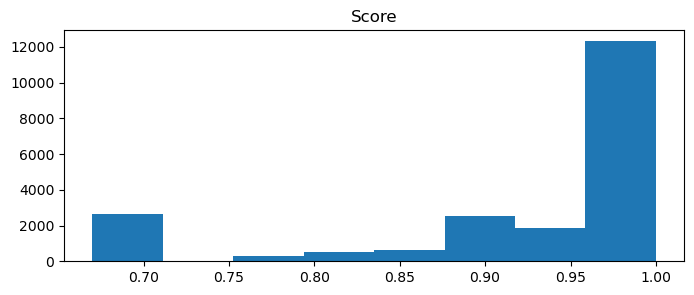

In [7]:
mrs = []
perfect = 0
for (read, hits) in getPrimerHits("Q8-sup_barcode01.fastq", maxReadsPerFile=10000, matchThreshold = 0.65):
    for hit in hits:
        mrs.append(hit.mr)
        if hit.mr == 1.0:
            perfect += 1

print("%d of %d (%d%%) of primer hits are a perfect match" % (perfect, len(mrs), 100*perfect/len(mrs)))
pd.DataFrame({'Score': mrs}).hist(figsize=(8,3), bins=8, grid=False);

## Read prefixes and suffxies

We expect to see an adapter, barcode and primer at the start and end of many reads, and barcode and primer at the end.
Sanity check this for one of the first reads (most others seem similar). 

In [36]:
for (read, hits) in getPrimerHits("Q8-sup_barcode01.fastq", maxReadsPerFile=1, skipReads=3, primers=adapters+barcodes+hrvPrimers):
    printHits(read, hits)

0194b466-3014-478a-9456-09293a0e052f 523
   0.89 3-40: LAt (36)
target quality      1111111110111112255579999999999999988   avg: 21
target              TTTGTGTCTTCTGTACTTCGTTCAGTTACGTATTGCT
                    |||.|.|.|.|||||||||||||||||||||||||||
query               TTTTTTT-TCCTGTACTTCGTTCAGTTACGTATTGCT

   1.00 40-80: NB01f (40)
target quality      9889999999999999999999999999999999999999   avg: 41
target              AAGGTTAACACAAAGACACCGACAACTTTCTTCAGCACCT
                    ||||||||||||||||||||||||||||||||||||||||
query               AAGGTTAACACAAAGACACCGACAACTTTCTTCAGCACCT

   0.90 80-100: Rhinovirus/Enterovirus 1 (21)
target quality      999999999899992268187   avg: 36
target              CAAGCACTTCTGTTTCCCGGT
                    ||||||||||||||||||.|.
query               CAAGCACTTCTGTTTCCCCGG

   1.00 453-474: Rhinovirus/Enterovirus 3 (21 rev)
target quality      666699998899999999999   avg: 41
target              ACTACTTTGGGTGTCCGTGTT
                    |||||||||||||||||||||


## Distribution of read lengths with hits.

HRV amplicons are expected to be about 390. But we expect 40bp & 45bp barcodes and a 36bp adapter.

Median length: 514, expected 514
Reads with at least 2 hits: 8101, length 464-564: 7956 (98%)


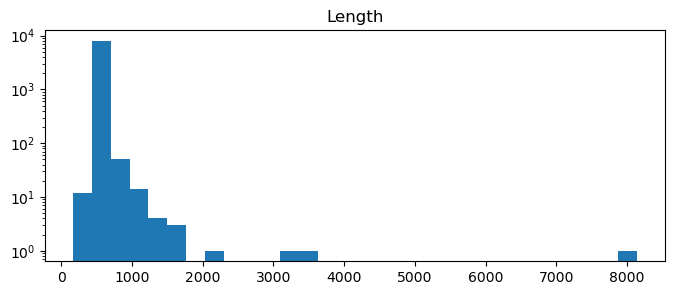

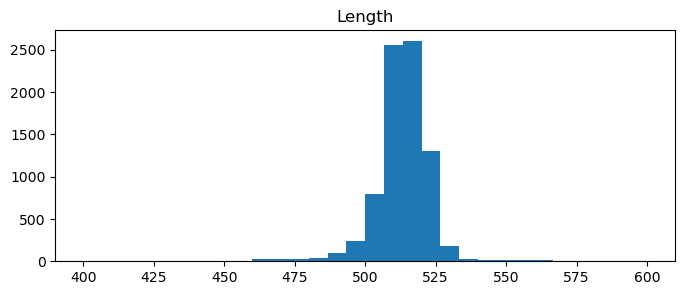

In [52]:
import matplotlib.pyplot as plt

EXPECTED_AMPLICON_LENGTH = 390
EXPECTED_PREFIX = 36 + 40 + 3
EXPECTED_SUFFIX = 45
EXPECTED_READ_LENGTH = EXPECTED_AMPLICON_LENGTH + EXPECTED_PREFIX + EXPECTED_SUFFIX
LENGTH_TOLERANCE = 50

def plotLengths(fastq):
    lens = []
    reads = 0
    withinTol = 0
    for (read, hits) in getPrimerHits(fastq, maxReadsPerFile=10000):
        if len(hits) < 2:
            continue
        reads += 1
        if abs(len(read) - EXPECTED_READ_LENGTH) < LENGTH_TOLERANCE:
            withinTol += 1
        lens.append(len(read))

    print("Median length: %d, expected %d" % (np.median(lens), EXPECTED_READ_LENGTH))
    print("Reads with at least 2 hits: %d, length %d-%d: %d (%d%%)" % 
          (reads, 
          EXPECTED_READ_LENGTH - LENGTH_TOLERANCE,
          EXPECTED_READ_LENGTH + LENGTH_TOLERANCE, 
          withinTol, 
          100*withinTol/reads))

    pd.DataFrame({'Length': lens}).hist(figsize=(8,3), bins=30, grid=False, log=True)
    plt.show()

    pd.DataFrame({'Length': lens}).hist(figsize=(8,3), bins=30, grid=False, range=(400, 600))
    plt.show()

plotLengths("Q8-sup_barcode01.fastq")

Check one of the mess full RespiCoV samples too. It's quite different, but that's probably due to primer-dimers and other artifacts. 

Median length: 1120, expected 514
Reads with at least 2 hits: 129, length 464-564: 7 (5%)


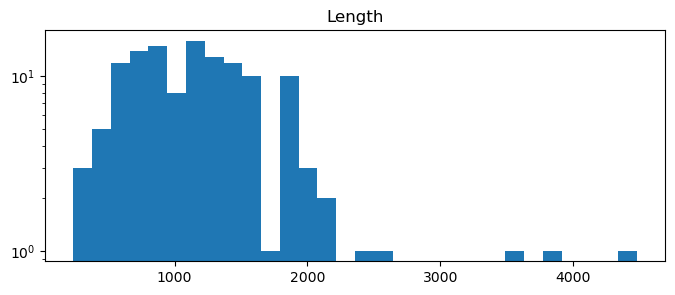

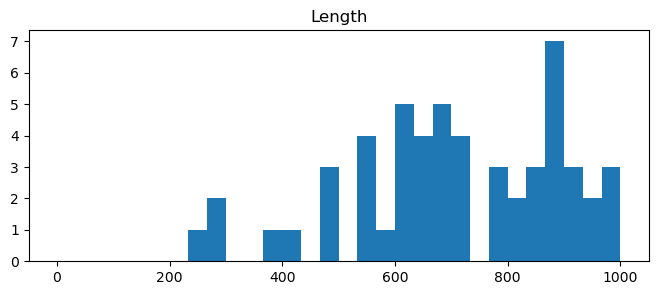

In [40]:
plotLengths("Q8-sup_barcode20.fastq")

## Distribution of hit locations

Perhaps we could make things a lot faster by looking only at the start and end of the read for hits? With dorado having done read splitting for us, perhaps we can skip barcodes and adapters and all find all legit primers at the start and end of reads?

Hits: 15914, exact: 365 (2%), within 20: 15782 (99%)


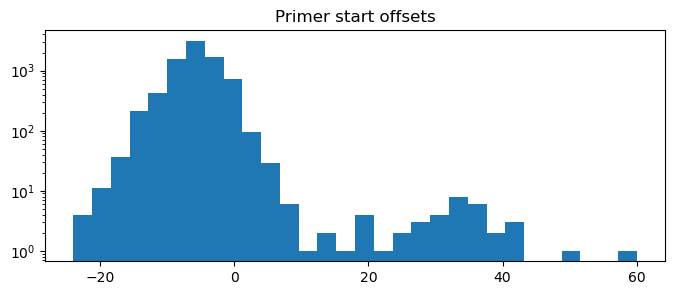

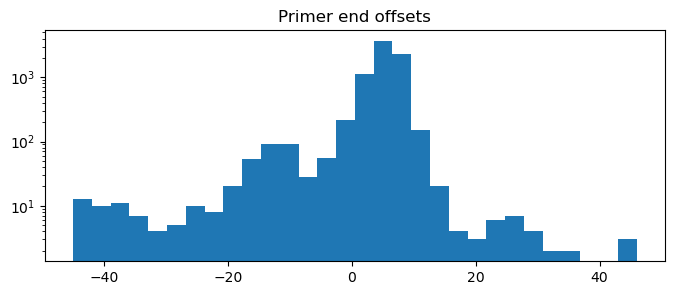

In [46]:
MAX_PRIMER_OFFSET = 20

def plotHitOffsets(fastq):
    sos = []
    eos = []
    hitCount = 0
    exactHit = 0
    withinTol = 0
    for (read, hits) in getPrimerHits(fastq, maxReadsPerFile=10000):
        if len(hits) < 2:
            continue
        if abs(len(read) - EXPECTED_READ_LENGTH) > LENGTH_TOLERANCE:
            continue
        for hit in hits:
            hitCount += 1
            so = hit.start - EXPECTED_PREFIX
            eo = len(read) - EXPECTED_SUFFIX - hit.end
            if min(so, eo) == 0:
                exactHit += 1
            if min(abs(so), abs(eo)) <= MAX_PRIMER_OFFSET:
                withinTol += 1
            if (abs(so) < abs(eo)):
                sos.append(so)
            else:
                eos.append(eo)

    print("Hits: %d, exact: %d (%d%%), within %d: %d (%d%%)" % (hitCount, exactHit, 100*exactHit/hitCount, MAX_PRIMER_OFFSET, withinTol, 100*withinTol/hitCount))
    df = pd.DataFrame({'Primer start offsets': sos})
    ax = df.hist(figsize=(8,3), bins=30, grid=False, log=True)
    plt.show()

    df = pd.DataFrame({'Primer end offsets': eos})
    ax = df.hist(figsize=(8,3), bins=30, grid=False, log=True)

plotHitOffsets("Q8-sup_barcode01.fastq")

And again on RespiCov

Hits: 14, exact: 0 (0%), within 20: 11 (78%)


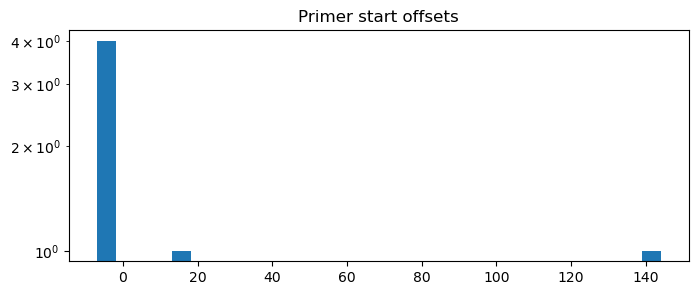

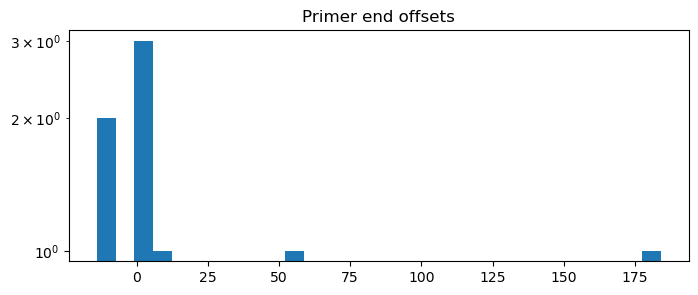

In [48]:
plotHitOffsets("Q8-sup_barcode20.fastq")

## Distribution of read qualities

We need a threshold for filtering out low-quality reads. Let's take a look at a sample distribution.
Note that this is shifted right significantly from the HAC basecaller (peak around Q18 with hac, Q28 here with sup).

Reads: 7957, qual p5: 19, qual reads: 7841 (98%)


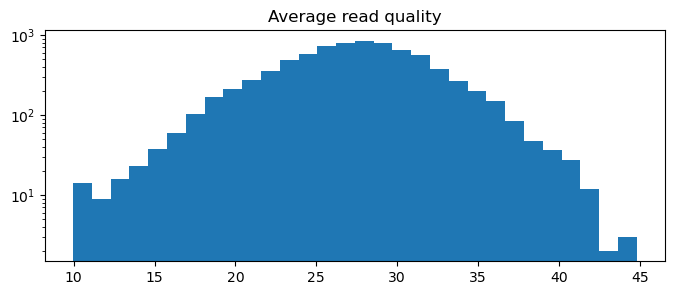

In [54]:
avgQuals = []
reads = 0
qualReads = 0
MIN_QUAL = 16

for (read, hits) in getPrimerHits("Q8-sup_barcode01.fastq", maxReadsPerFile=10000):
    if len(hits) < 2:
        continue
    if abs(len(read) - EXPECTED_READ_LENGTH) > LENGTH_TOLERANCE:
        continue
    reads += 1
    aq = np.mean(read.letter_annotations["phred_quality"])
    avgQuals.append(aq)
    if (aq >= MIN_QUAL):
        qualReads += 1

print ("Reads: %d, qual p5: %d, qual reads: %d (%d%%)" % (reads, np.percentile(avgQuals, 5), qualReads, 100*qualReads/reads))
df = pd.DataFrame({'Average read quality': avgQuals})
ax = df.hist(figsize=(8,3), bins=30, grid=False, log=True)
plt.show()


# Make cached HRV read files with optimized hit finding

Based on the above we can search just for primers at the start and end of reads, and with reads of at least Q16, and save them to their own files.

In [65]:
import gzip
from Bio import SeqIO
import time
maxPrimer = max([len(p.seq) for p in hrvPrimers])
fs = EXPECTED_PREFIX - MAX_PRIMER_OFFSET
fe = EXPECTED_PREFIX + MAX_PRIMER_OFFSET + maxPrimer
rs = - EXPECTED_SUFFIX - MAX_PRIMER_OFFSET - maxPrimer
re = - EXPECTED_SUFFIX + MAX_PRIMER_OFFSET

print("Trimming to %d-%d and %d-%d" % (fs, fe, rs, re))

for inFile in sorted(filter(lambda f: f.endswith(".fastq"), os.listdir(fastQDir))):
    hrvFile = os.path.join(hrvDir, "HRV-" + inFile)
    if os.path.exists(hrvFile):
        print("Skipping existing file:", hrvFile)
        continue
    # Extract the portion of the filename after the _ and before the .
    fnSuffix = inFile.split("_")[1].split(".")[0]

    with open(hrvFile, "wt") as out:
        inPath = os.path.join(fastQDir, inFile)
        print("Processing", os.path.basename(inPath), end="")
        reads = 0
        hitReads = 0
        start = time.process_time()
        for read in RCUtils.readFastQ(inPath):
            reads += 1
            if reads % 10000 == 0:
                print(".",end="")

            if abs(len(read) - EXPECTED_READ_LENGTH) > LENGTH_TOLERANCE:
                continue
            
            aq = np.mean(read.letter_annotations["phred_quality"])
            if aq < MIN_QUAL:
                continue

            # Look for a primer hit at the start and end of the read
            startHits = RCUtils.computePrimerHits(read[fs:fe], hrvPrimers)
            if not startHits:
                continue
            startHit = startHits[-1]
            endHits = RCUtils.computePrimerHits(read[rs:re], hrvPrimers)
            if not endHits:
                continue
            endHit = endHits[0]
            
            # One primer should be the forward one and one should be reverse
            if startHit.primer is endHit.primer:
                continue

            hitReads += 1

            # Trim the read to the primer hits and add the barcode
            origQual = read.letter_annotations["phred_quality"]
            read.letter_annotations = {}
            read.seq = read.seq[fs+startHit.start:rs+endHit.end]
            read.letter_annotations["phred_quality"] = origQual[fs+startHit.start:rs+endHit.end]
            read.id = read.id + "_" + fnSuffix

            SeqIO.write(read, out, "fastq")

        elapsed = time.process_time() - start
        print("")
        print("  %d reads, %d with hits (%d%%). %.2fs" % (reads, hitReads, hitReads * 100 / reads if reads else 0, elapsed))


Trimming to 59-120 and -86--25
Processing Q8-sup_barcode01.fastq............................................................................................................................................................
  1569821 reads, 1234718 with hits (78%). 277.52s
Processing Q8-sup_barcode02.fastq.............................
  294013 reads, 232364 with hits (79%). 50.24s
Processing Q8-sup_barcode03.fastq...........................................................................
  755149 reads, 634005 with hits (83%). 136.96s
Processing Q8-sup_barcode04.fastq...............................
  311277 reads, 247643 with hits (79%). 54.06s
Processing Q8-sup_barcode05.fastq.........................................
  415175 reads, 345963 with hits (83%). 74.65s
Processing Q8-sup_barcode06.fastq...................................................
  510326 reads, 423580 with hits (83%). 90.73s
Processing Q8-sup_barcode07.fastq...............................................................

ZeroDivisionError: division by zero

There's often multiple hits, check out a few to make sure they match the expected pattern of outer concatemers. 

In [63]:
for read in RCUtils.readFastQ(os.path.join(fastQDir, "Q8-sup_barcode01.fastq")):
    if read.id == "8a73e783-6db7-4857-b5a8-f06a5f58cadc" or \
        read.id == "2e53d223-7b5d-4738-8deb-e8da5522caf8" or \
        read.id == "ead570db-492a-4f58-ade9-382ae910c82b":
        hits = RCUtils.computePrimerHits(read, hrvPrimers)
        printHits(read, hits)
        if read.id == "ead570db-492a-4f58-ade9-382ae910c82b":
            break

8a73e783-6db7-4857-b5a8-f06a5f58cadc 539
   1.00 75-96: Rhinovirus/Enterovirus 1 (21)
target quality      987899999999999899969   avg: 39
target              CAAGCACTTCTGTTTCCCCGG
                    |||||||||||||||||||||
query               CAAGCACTTCTGTTTCCCCGG

   1.00 97-118: Rhinovirus/Enterovirus 1 (21)
target quality      987899999999999899969   avg: 39
target              CAAGCACTTCTGTTTCCCCGG
                    |||||||||||||||||||||
query               CAAGCACTTCTGTTTCCCCGG

   1.00 467-488: Rhinovirus/Enterovirus 3 (21 rev)
target quality      999777779999999999999   avg: 41
target              ACTACTTTGGGTGTCCGTGTT
                    |||||||||||||||||||||
query               ACTACTTTGGGTGTCCGTGTT

2e53d223-7b5d-4738-8deb-e8da5522caf8 540
   1.00 75-96: Rhinovirus/Enterovirus 1 (21)
target quality      999999999999999999999   avg: 42
target              CAAGCACTTCTGTTTCCCCGG
                    |||||||||||||||||||||
query               CAAGCACTTCTGTTTCCCCGG

   1.00 96-117:

## Clustering

Cluster the results by pairwise similarity using the VSearch program. Use a low identity threshold to start, we can always split clusters further. Clustering is expensive and it's nice to be able to watch the progress. So rather than execute here directly, just copy the results from a terminal

```
%%bash
# Invoke a shell command to cluster the reads
cd ../Q8/reads-sup-hrv
rm clusters/*
cat *.fastq | ../../vsearch-2.28.1-macos-aarch64/bin/vsearch --cluster_fast - --id 0.70 --centroids clusters/centroids.fasta --uc clusters/clusters.uc --consout clusters/consensus.fasta --clusters clusters/clout  --clusterout_sort

vsearch v2.28.1_macos_aarch64, 16.0GB RAM, 8 cores
https://github.com/torognes/vsearch

Reading file all.fastq 100%  
1262137718 nt in 3223575 seqs, min 320, max 440, avg 392
Masking 100% 
Sorting by length 100%
Counting k-mers 100% 
Clustering 100%  
Sorting clusters 100%
Writing clusters 100% 
Clusters: 2258 Size min 1, max 456421, avg 1427.6
Singletons: 758, 0.0% of seqs, 33.6% of clusters
Multiple alignments 100% 

```

In [129]:
(clusters, clusterIdsBySize) = parseUclust(os.path.join(hrvDir, "clusters/clusters.uc"))
print("Read %d clusters" % len(clusters))

Read 1304 clusters


## Distribution of sizes of clusters

Largest cluster sizes: [555728, 546463, 400595, 397987, 232919, 231073, 210938, 208003, 186250, 183796]


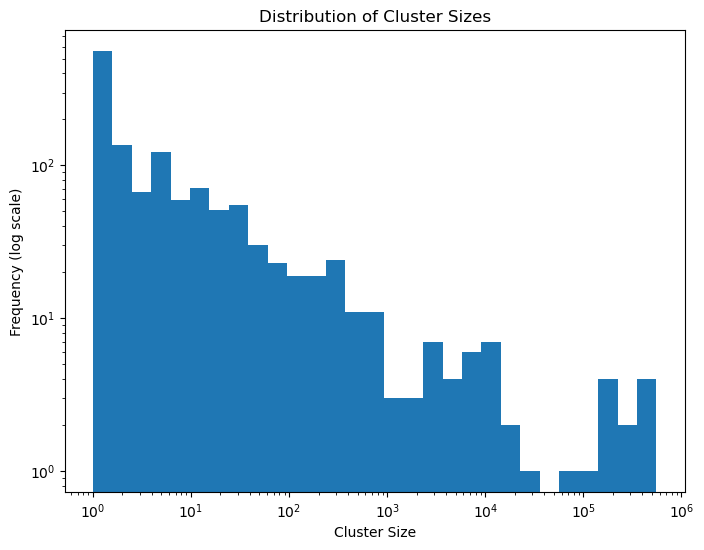

,Count
Cluster Size,
Size 1,560
Size 2,136
Size 3,67
Size 4,58
Size >4,483


In [102]:
import numpy as np

import matplotlib.pyplot as plt

print("Largest cluster sizes:", [clusters[c]['cluster_size'] for c in clusterIdsBySize[:10]])

cluster_sizes = [c['cluster_size'] for c in clusters.values()]

plt.figure(figsize=(8, 6))
plt.hist(cluster_sizes, bins=np.logspace(np.log10(1), np.log10(max(cluster_sizes)), 30), log=True)
plt.xscale('log')
plt.xlabel('Cluster Size')
plt.ylabel('Frequency (log scale)')
plt.title('Distribution of Cluster Sizes')
plt.show()

cluster_counts = {
    'Size 1': 0,
    'Size 2': 0,
    'Size 3': 0,
    'Size 4': 0,
    'Size >4': 0
}

for size in cluster_sizes:
    if size == 1:
        cluster_counts['Size 1'] += 1
    elif size == 2:
        cluster_counts['Size 2'] += 1
    elif size == 3:
        cluster_counts['Size 3'] += 1
    elif size == 4:
        cluster_counts['Size 4'] += 1
    else:
        cluster_counts['Size >4'] += 1

cluster_table = pd.DataFrame.from_dict(cluster_counts, orient='index', columns=['Count'])
cluster_table.index.name = 'Cluster Size'
cluster_table

## Remove all the clusters of size 3 or less

These are too small to have a meaningful consensus, and likely just represent an unlucky string of errors.

In [103]:
MIN_CLUSTER_SIZE = 4
removed = 0

# walk the clusters by increasing size
while clusterIdsBySize:
    cluster_id = clusterIdsBySize.pop()
    cluster = clusters[cluster_id]
    if cluster['cluster_size'] >= MIN_CLUSTER_SIZE:
        break
    clout = os.path.join(hrvDir, "clusters/clout%d" % cluster_id)
    if os.path.exists(clout):
        os.remove(clout)
    del clusters[cluster_id]
    removed += 1

print("Removed %d clusters" % removed)

Removed 763 clusters


## Similarity histograms for the largest clusters

Plot histograms of the similarity index. It's intresting that most top out around 85%. That probably represents the ~15% error that happened to be present in the centroid read. 

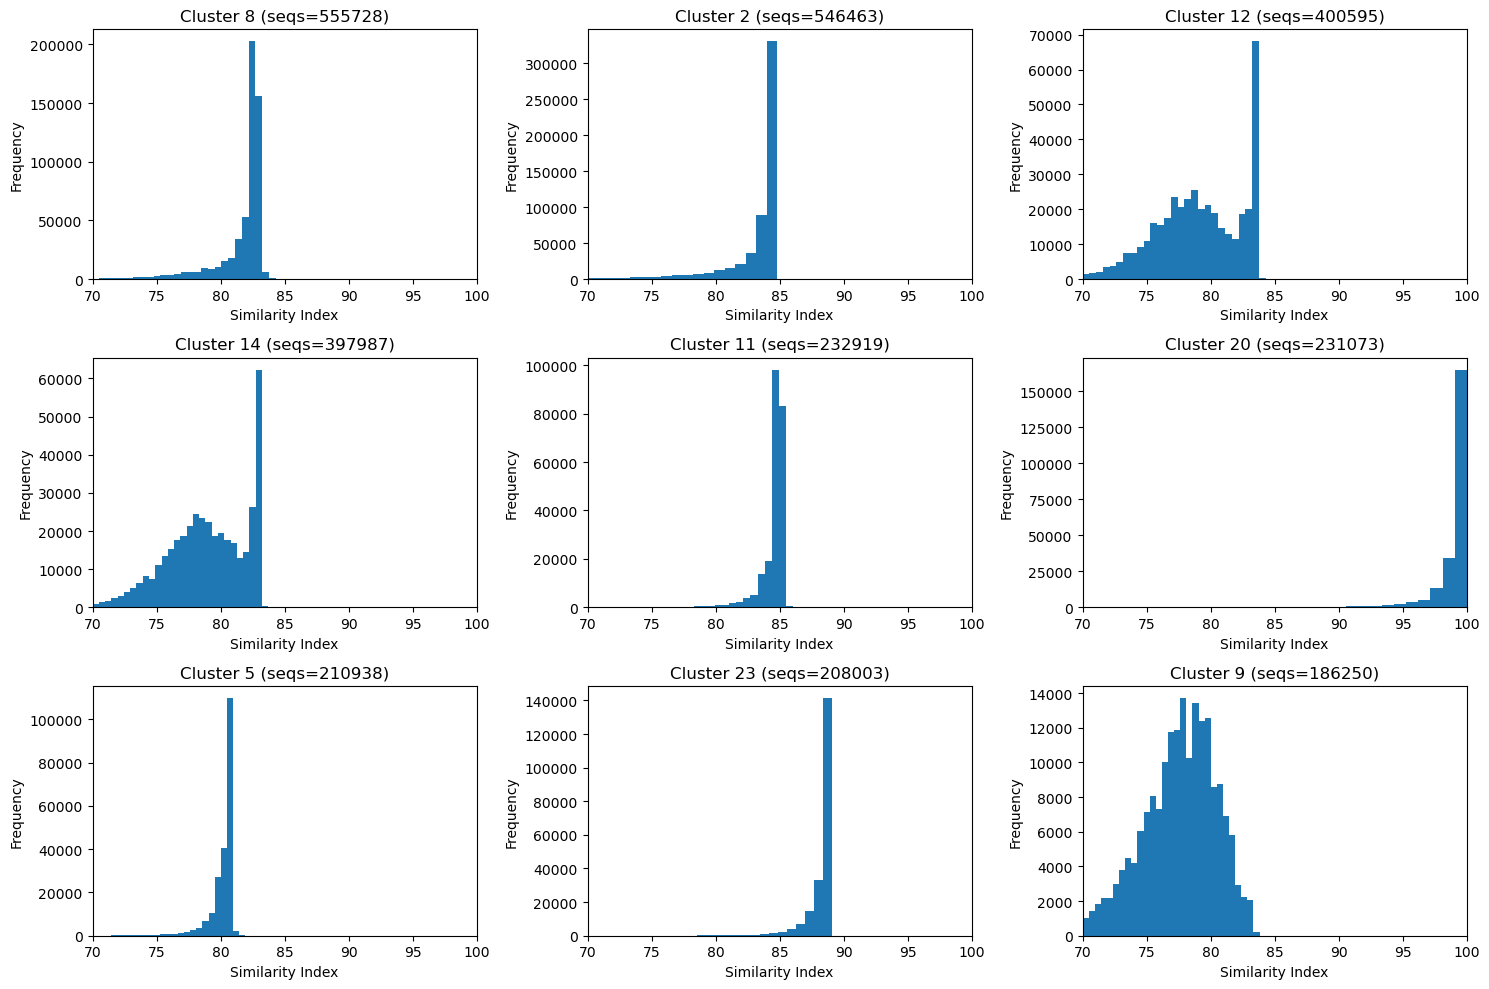

In [133]:
topClusters = [clusters[clusterIdsBySize[i]] for i in range(9)]

# plot a histogram of the similarity index for the first cluster
fig, axs = plt.subplots(3, 3, figsize=(15, 10))

for i, c in enumerate(topClusters):
    a = axs[i//3, i%3]
    a.set_xlim(70, 100)
    #a.set_ylim(0, 200000)
    similarity_indices = [float(hit['similarity']) for hit in c['hits']]
    a.hist(similarity_indices, bins=30)
    a.set_xlabel('Similarity Index')
    a.set_ylabel('Frequency')
    a.set_title(f'Cluster {c["id"]} (seqs={c["cluster_size"]})')

plt.tight_layout()
plt.show()


## Plot the barcode distribution of the top clusters

It looks like clusters do a pretty good job of being tied to a single barcode. Notable exceptions are barcode05/03 which turned out both to be nearly identical Rhinovirus-C11 and barcode01 which seems to be an odd mix of things.

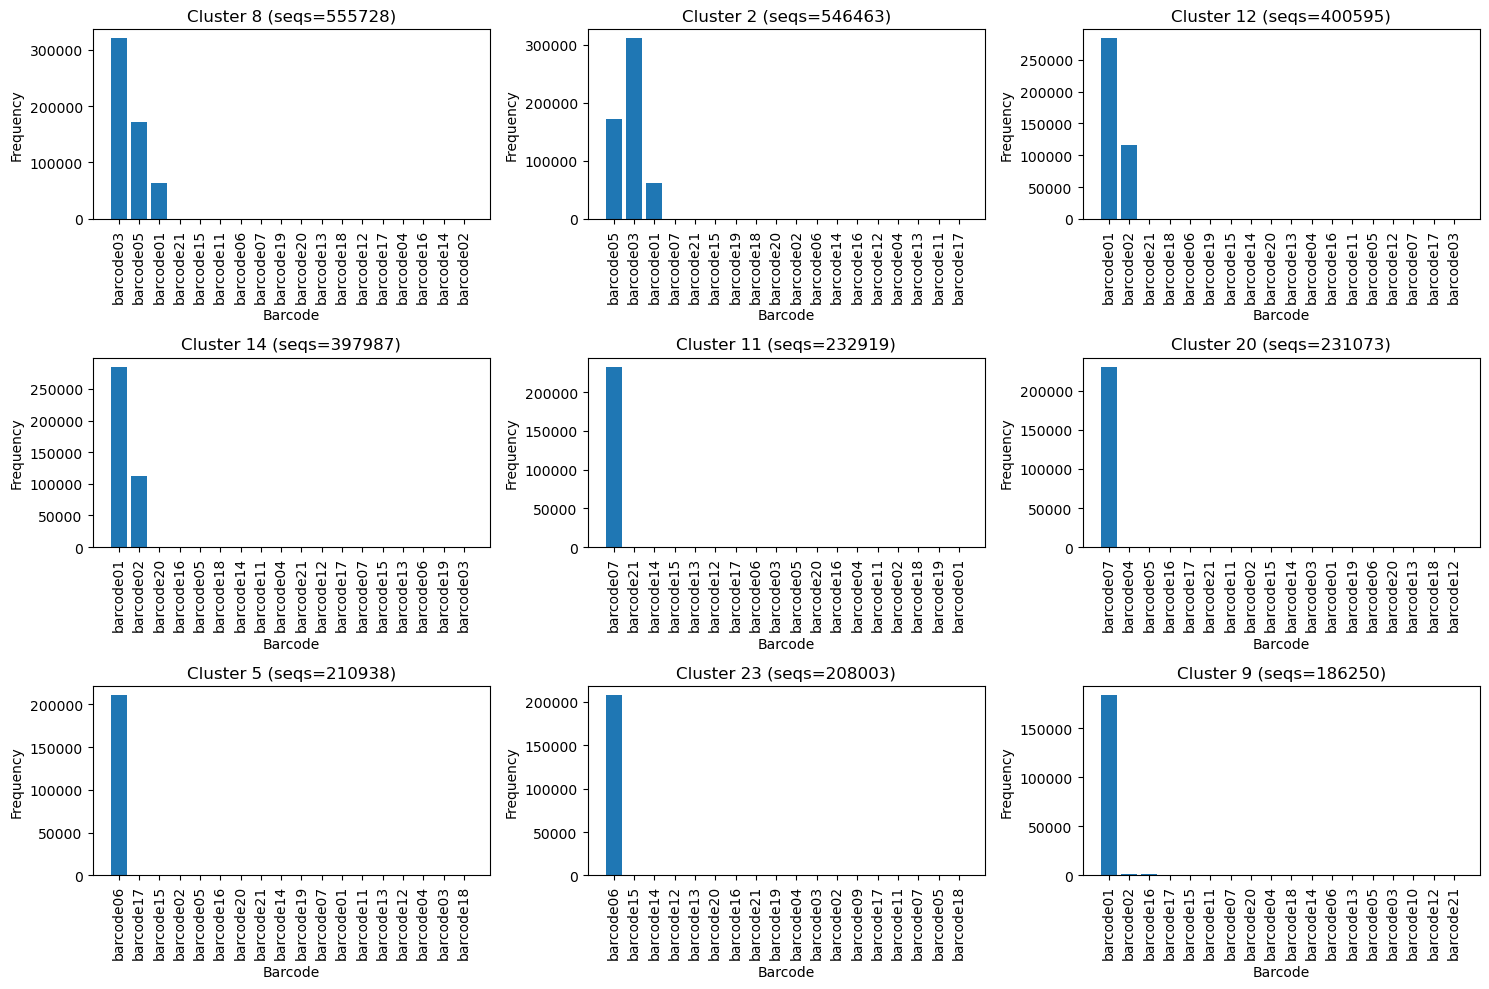

In [134]:
from collections import Counter

fig, axs = plt.subplots(3, 3, figsize=(15, 10))

for i, c in enumerate(topClusters):
    barcodes = [hit['readId'].split('_')[1] for hit in c['hits']]
    barcode_counts = Counter(barcodes)
    a = axs[i//3, i%3]
    a.bar(barcode_counts.keys(), barcode_counts.values())
    a.set_xlabel('Barcode')
    a.set_ylabel('Frequency')
    a.set_title(f'Cluster {c["id"]} (seqs={c["cluster_size"]})')
    a.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


## Dig into barcode01 clusters

Minimap fails to produce a good consensus for barcode01 and inspecting the reads shows a high abundance of two difference sequences which appear to be other samples we already have. Try matching against all of our existing HRV samples: 

In [176]:
%%bash
cd ../Q8/reads-sup-hrv/
mkdir -p barcode01
cd barcode01 
cat ../../../RespiCov-analyze/myseqs/*RV*.fastq > myhrvs.fastq
# --gapopen 0ET allows the query to match the full target (null gap open/close penalties on the target extremities)
../../../vsearch-2.28.1-macos-aarch64/bin/vsearch --usearch_global ../HRV-q8-sup_barcode01.fastq --db myhrvs.fastq --id 0.80 --gapopen 0ET --gapext 0ET --notmatched myhrvs_notmatched.fastq --strand both --blast6out myhrvs.blast6

vsearch v2.28.1_macos_aarch64, 16.0GB RAM, 8 cores
https://github.com/torognes/vsearch

Reading file myhrvs.fastq 100%
3513 nt in 10 seqs, min 348, max 354, avg 351
Masking 100%
Counting k-mers 100%
Creating k-mer index 100%
Searching 100%
Matching unique query sequences: 832753 of 1234718 (67.44%)
Searching 100%
Matching unique query sequences: 1216244 of 1234718 (98.50%)


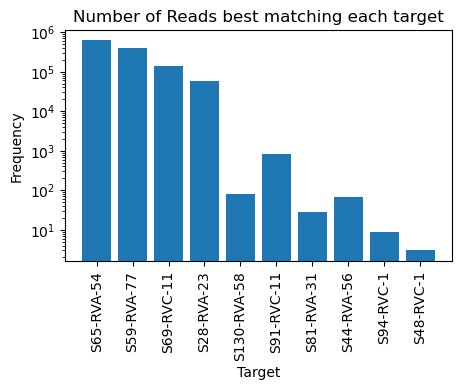

In [184]:
# Read the blast6 output, a tab separated file with the following columns:
# 1. Query ID
# 2. Target ID
# 3. Percent identity
matchesByRead = {}
scoresByTarget = {}
with open(os.path.join(hrvDir, "barcode01/myhrvs.blast6")) as f:
    for line in f:
        columns = line.strip().split('\t')
        readId = columns[0]
        target = columns[1]
        score = float(columns[2])
        matchesByRead[readId] = {
            'target': target,
            'identity': score
        }
        if target not in scoresByTarget:
            scoresByTarget[target] = []
        scoresByTarget[target].append(score)

# Plot a histogram of the number of reads for each target
target_counts = Counter([match['target'] for match in matchesByRead.values()])
plt.figure(figsize=(5, 3))
plt.bar(target_counts.keys(), target_counts.values())
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.tick_params(axis='x', rotation=90)
plt.yscale('log')  # Set y-axis to log scale
plt.title('Number of Reads best matching each target')
plt.show()

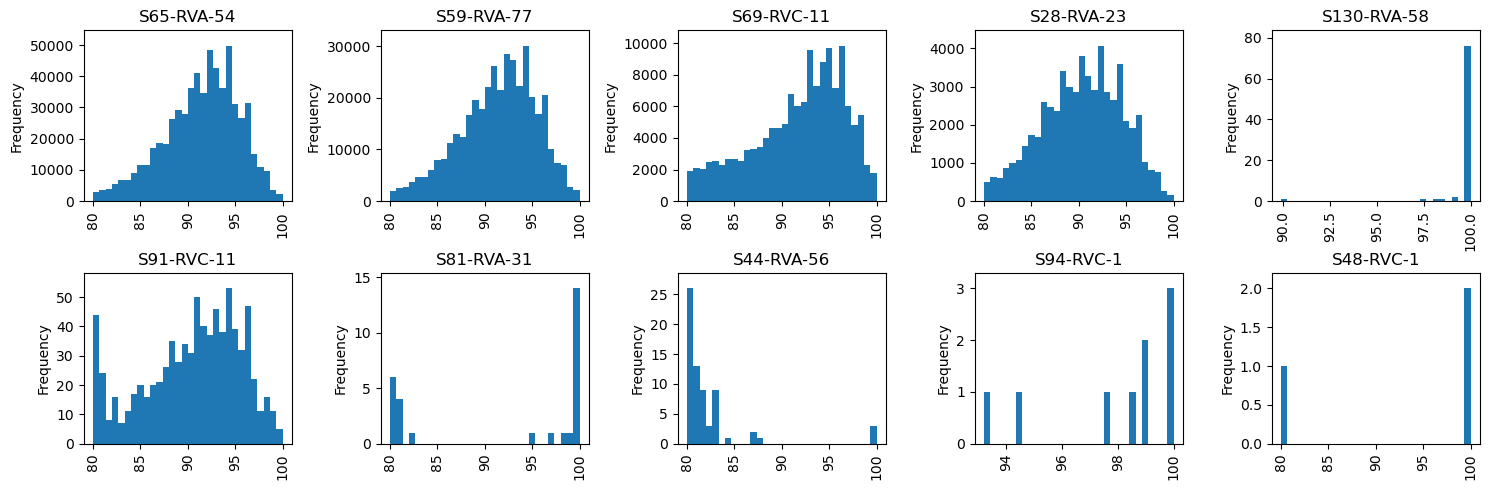

In [189]:
# Plot histogram of the match scores against each target
fig, axs = plt.subplots(2, 5, figsize=(15, 5))

for i, tgt in enumerate(list(scoresByTarget.keys())):
    a = axs[i//5, i%5]
    identity_values = [match['identity'] for match in matchesByRead.values() if match['target'] == tgt]
    a.hist(identity_values, bins=30)
    a.set_ylabel('Frequency')
    a.set_title(tgt)
    a.tick_params(axis='x', rotation=90)
    a.margins(y=0.1)  # Add vertical space

plt.tight_layout()
plt.show()
